In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [38]:
df = pd.read_csv("Bjorge_et_al_catchlogbook_whaling_weather_data_1932-63_data_publication.csv")

dlta = df[['date', 'Latitude', 'Temp (sea)']].copy()
dlta.dropna(inplace=True)
dlta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4950 entries, 148 to 6280
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        4950 non-null   object 
 1   Latitude    4950 non-null   float64
 2   Temp (sea)  4950 non-null   float64
dtypes: float64(2), object(1)
memory usage: 154.7+ KB


In [39]:
dlta['month'] = pd.to_datetime(dlta['date']).dt.month
dlta['year'] = pd.to_datetime(dlta['date']).dt.year

# Cyclic transformation of month
dlta['month_sin'] = np.sin(2 * np.pi * dlta['month'] / 12)
dlta['month_cos'] = np.cos(2 * np.pi * dlta['month'] / 12)

# Normalize year
dlta['year'] = (dlta['year'] - dlta['year'].mean()) / dlta['year'].std()


In [45]:
# Define feature and target
X = dlta[['year', 'month_sin', 'month_cos' , 'Latitude']]
y = dlta['Temp (sea)']

In [46]:
# Fit Linear Regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [47]:
# Predict and evaluate
y_pred = model.predict(X)
r2  = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred)

# Print coefficients and evaluation metrics
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")
print("Intercept:", model.intercept_)
print("R^2:", r2)
print("RMSE:", rmse)

year: 0.029825406013657692
month_sin: 0.6484302673721376
month_cos: -0.5587926834212589
Latitude: 0.33210415971707496
Intercept: 20.979129024376984
R^2: 0.6652604476481081
RMSE: 3.121322445612127


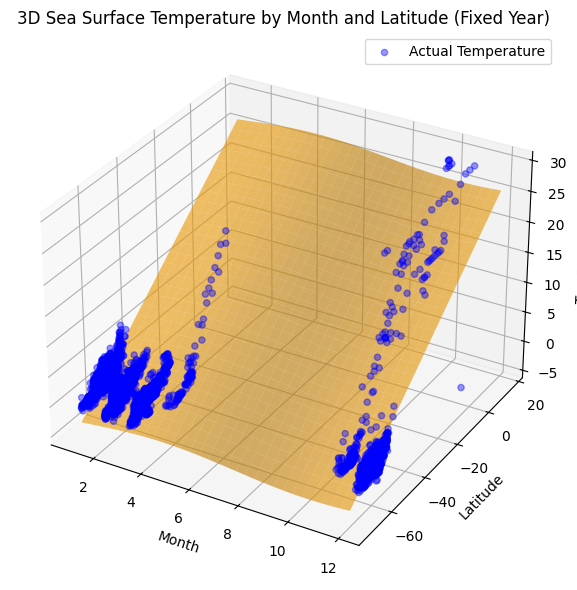

In [48]:
# Create grid of raw months and latitudes
month_vals = np.linspace(dlta['month'].min(), dlta['month'].max(), 30)
lat_vals = np.linspace(dlta['Latitude'].min(), dlta['Latitude'].max(), 30)
month_grid, lat_grid = np.meshgrid(month_vals, lat_vals)

# Compute cyclic encodings for month
month_sin = np.sin(2 * np.pi * month_grid / 12)
month_cos = np.cos(2 * np.pi * month_grid / 12)

# Use the normalized average year (since you scaled it)
avg_year = 0  # Because you normalized year: (year - mean) / std

# Prepare full feature grid for prediction
X_grid = np.c_[
    np.full(month_grid.size, avg_year),
    month_sin.ravel(),
    month_cos.ravel(),
    lat_grid.ravel()
]

# Optionally convert to DataFrame with feature names to avoid warnings
X_grid_df = pd.DataFrame(X_grid, columns=X.columns)

# Predict temperatures
temp_pred_grid = model.predict(X_grid_df).reshape(month_grid.shape)

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dlta['month'], dlta['Latitude'], y, color='blue', label='Actual Temperature', alpha=0.4)
ax.plot_surface(month_grid, lat_grid, temp_pred_grid, color='orange', alpha=0.6)

ax.set_xlabel('Month')
ax.set_ylabel('Latitude')
ax.set_zlabel('Temperature')
ax.set_title('3D Sea Surface Temperature by Month and Latitude (Fixed Year)')
plt.legend()
plt.tight_layout()
plt.show()


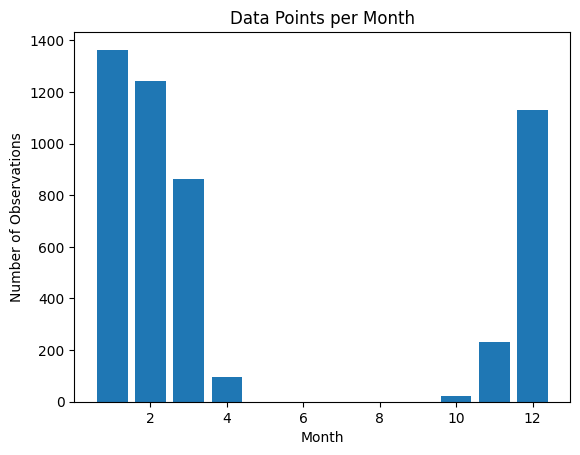

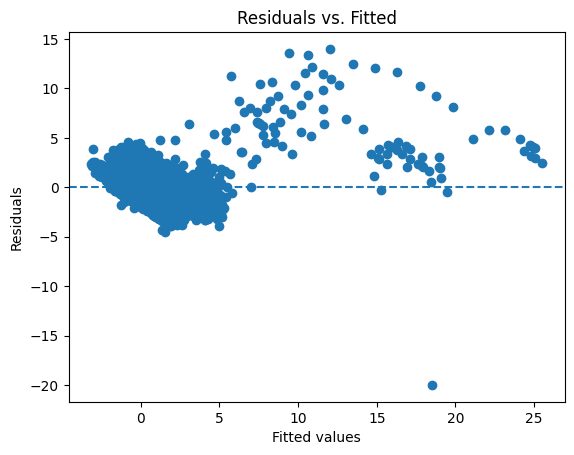

In [49]:
# 9b. Bar chart of counts per month
plt.figure()
counts = dlta['month'].value_counts().sort_index()
plt.bar(counts.index, counts.values)
plt.xlabel('Month')
plt.ylabel('Number of Observations')
plt.title('Data Points per Month')
plt.show()

# 9c. Residuals vs. fitted values
residuals = y - y_pred
plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

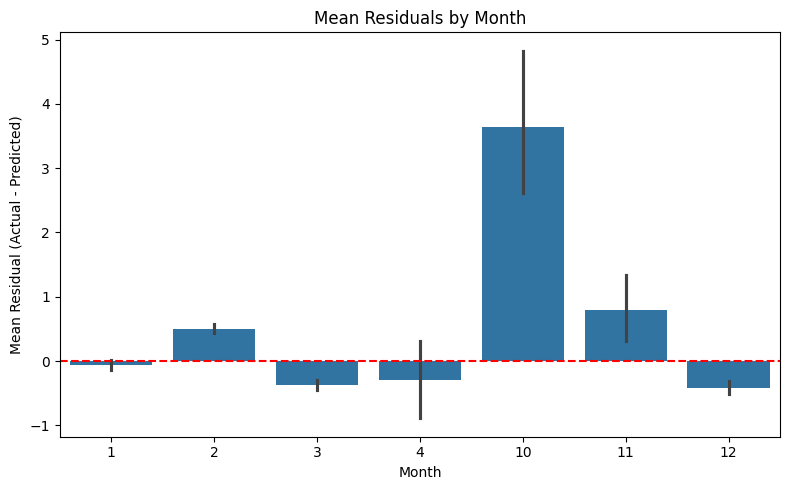

In [50]:
# Make sure 'residuals', 'month', and 'y_pred' exist
dlta['residuals'] = y - y_pred
dlta['fitted'] = y_pred

# Plot mean residuals per month
plt.figure(figsize=(8, 5))
sns.barplot(x='month', y='residuals', data=dlta)
plt.axhline(0, color='red', linestyle='--')
plt.title('Mean Residuals by Month')
plt.ylabel('Mean Residual (Actual - Predicted)')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

C:\Users\dangv\AppData\Local\Temp\ipykernel_24476\3793070708.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='month', y='residuals', data=dlta, estimator=np.std, ci=None)


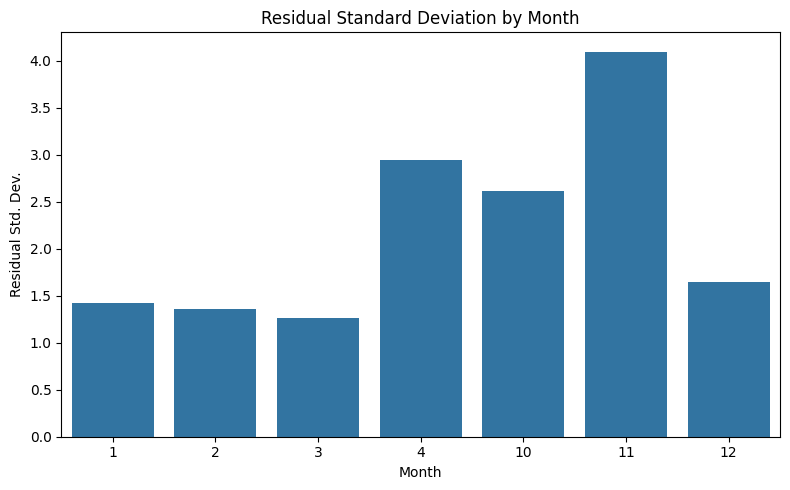

In [51]:
# Plot standard deviation of residuals per month
plt.figure(figsize=(8, 5))
sns.barplot(x='month', y='residuals', data=dlta, estimator=np.std, ci=None)
plt.title('Residual Standard Deviation by Month')
plt.ylabel('Residual Std. Dev.')
plt.xlabel('Month')
plt.tight_layout()
plt.show()


In [54]:
# Build pipeline with polynomial features
poly_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)

poly_model.fit(X, y)
y_pred_poly = poly_model.predict(X)

In [55]:
print("R^2:", r2_score(y, y_pred_poly))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred_poly)))

R^2: 0.7572036429159317
RMSE: 1.5046548361610432


In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = dlta[['year', 'month_sin', 'month_cos', 'Latitude']]
y = dlta['Temp (sea)']

# Split for performance evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

# Metrics
r2 = r2_score(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
residuals = y_test - y_pred_rf

Random Forest R²: 0.8814356710213761
Random Forest RMSE: 1.0063026760016796


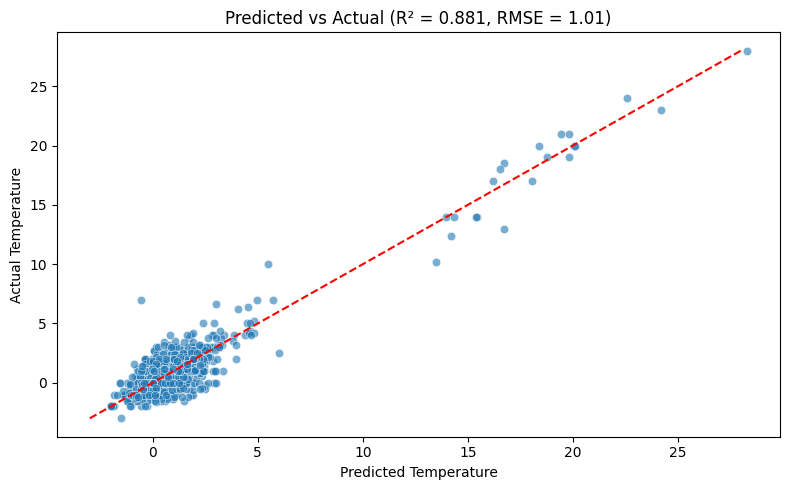

In [60]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_rf, y=y_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Predicted Temperature')
plt.ylabel('Actual Temperature')
plt.title(f'Predicted vs Actual (R² = {r2_score(y_test, y_pred_rf):.3f}, RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f})')
plt.tight_layout()
plt.show()

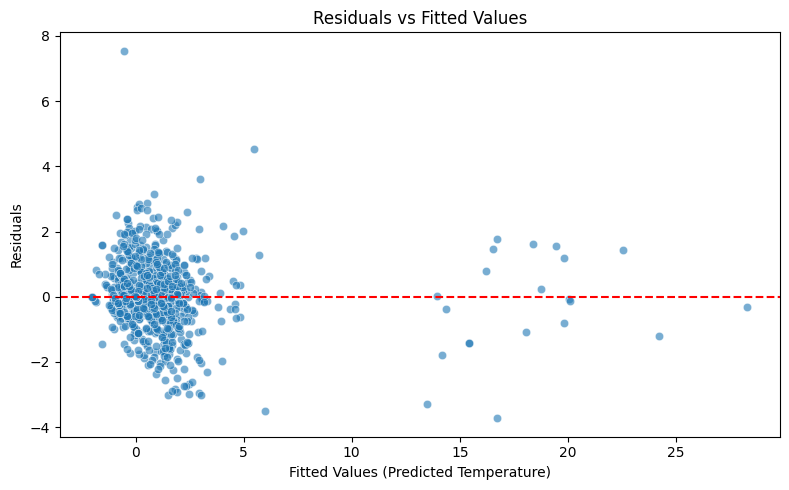

In [69]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_rf, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predicted Temperature)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.tight_layout()
plt.show()


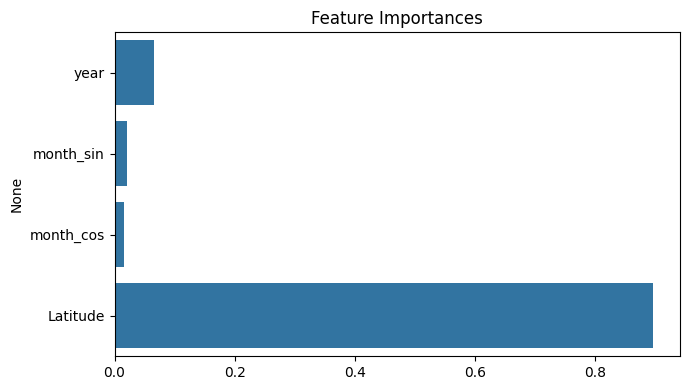

In [70]:
plt.figure(figsize=(7, 4))
sns.barplot(x=rf.feature_importances_, y=X.columns)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [72]:
# --- Prepare your grid (month vs latitude) ---
month_vals = np.linspace(1, 12, 40)
lat_vals = np.linspace(dlta['Latitude'].min(), dlta['Latitude'].max(), 40)
month_grid, lat_grid = np.meshgrid(month_vals, lat_vals)

# Encode cyclic month features
month_sin_grid = np.sin(2 * np.pi * month_grid / 12)
month_cos_grid = np.cos(2 * np.pi * month_grid / 12)

# Fixed year (mean-centered, so use 0 if standardized)
fixed_year = 0
grid_data = np.c_[
    np.full(month_grid.size, fixed_year),  # year
    month_sin_grid.ravel(),
    month_cos_grid.ravel(),
    lat_grid.ravel()
]

# --- Train and predict with Polynomial Regression ---
X = dlta[['year', 'month_sin', 'month_cos', 'Latitude']]
y = dlta['Temp (sea)']
poly_model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
poly_model.fit(X, y)
z_poly = poly_model.predict(grid_data).reshape(month_grid.shape)

# --- Train and predict with Random Forest ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
z_rf = rf_model.predict(grid_data).reshape(month_grid.shape)


c:\Users\dangv\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\dangv\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


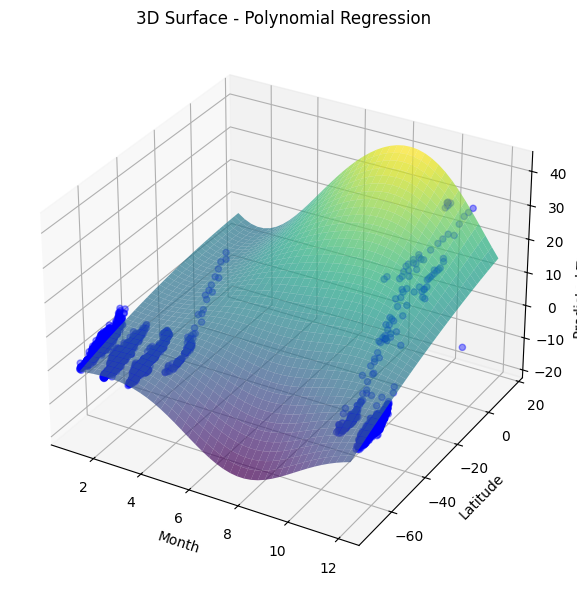

In [75]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dlta['month'], dlta['Latitude'], y, color='blue', label='Actual Temperature', alpha=0.4)
ax.plot_surface(month_grid, lat_grid, z_poly, cmap='viridis', alpha=0.7)
ax.set_xlabel("Month")
ax.set_ylabel("Latitude")
ax.set_zlabel("Predicted Temperature")
ax.set_title("3D Surface - Polynomial Regression")
plt.tight_layout()
plt.show()


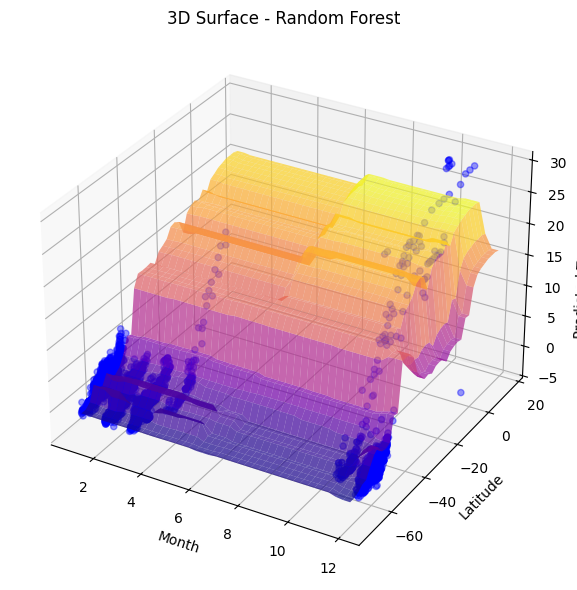

In [76]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dlta['month'], dlta['Latitude'], y, color='blue', label='Actual Temperature', alpha=0.4)
ax.plot_surface(month_grid, lat_grid, z_rf, cmap='plasma', alpha=0.7)
ax.set_xlabel("Month")
ax.set_ylabel("Latitude")
ax.set_zlabel("Predicted Temperature")
ax.set_title("3D Surface - Random Forest")
plt.tight_layout()
plt.show()
